Throught this kernel I'm going to made a model for the  [Human Protein Atlas Image Classification](https://www.kaggle.com/c/human-protein-atlas-image-classification) competition. Our models should be able to classify mixed patterns of proteins in microscope images. That means **this is a multilabel classification problem** so each sample could have more than one label.

As we have a really huge dataset, I will load "batches" of samples each time I train the model. The way I'll train the model will be:

- Randomly load samples from the dataset based on the amount of samples of each type (for me, a type is a possible combination of labels) (proportionally).
- Train the model with these samples (a few epochs)
- Reload (randomly) another dataset and repeat  as long as it is required;

Moreover, as I will train the model on a kaggle kernel, I will store my models in a dropbox remote directory and load them from it in order to stop training when needed and be able to continue training that model in other moment.

![process](http://i67.tinypic.com/33dza6u.png)

There are 28 possible label for a sample. Let's start with defining these possible labels and our data paths:

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import copy


from PIL import Image

DATASET_SIZE = 8000
BATCH_SIZE = 200
W = H = 256

train_path = './data/train/'
test_path = './data/test/'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

LABELS = []

for label in LABEL_MAP.values():
    LABELS.append(label)
    
train_csv_path = './data/train.csv'

we have 31072 different samples
And there are 582 different combinations of labels in our dataset


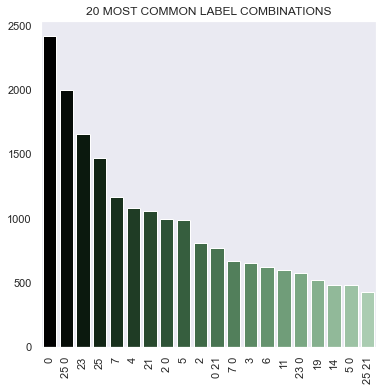

In [4]:
df = pd.read_csv(train_csv_path)

TRAINING_SAMPLES = df.shape[0]

print("we have " + str(TRAINING_SAMPLES) + " different samples")
print("And there are "+  str(len(df.Target.unique())) + " different combinations of labels in our dataset")

import seaborn as sns
sns.set(style="dark")

n = 20

values = df['Target'].value_counts()[:n].keys().tolist()
counts = df['Target'].value_counts()[:n].tolist()

plt.figure(figsize=(6,6))
pal = sns.cubehelix_palette(n, start=2, rot=0, dark=0, light=.75, reverse=True)
g = sns.barplot(y=counts, x=values, palette=pal)
g.set_title(str(n)+" MOST COMMON LABEL COMBINATIONS")
g.set_xticklabels(g.get_xticklabels(),rotation=90);

Now, how to load our images for a given id:

In [5]:
from PIL import Image

def load_image(basepath, image_id):
    images = np.zeros(shape=(256,256,4))
    r = Image.open(basepath+image_id+"_red.png").resize((256,256))
    g = Image.open(basepath+image_id+"_green.png").resize((256,256))
    b = Image.open(basepath+image_id+"_blue.png").resize((256,256))
    y = Image.open(basepath+image_id+"_yellow.png").resize((256,256))

    images[:,:,0] = np.asarray(r)
    images[:,:,1] = np.asarray(g)
    images[:,:,2] = np.asarray(b)
    images[:,:,3] = np.asarray(y)
    
    return images

As our dataset is huge, I will calculate the portion of it that correspond to each possible combination of labels and I will use this value to decide how many samples of each type (combination of labels) I will use for training.

In [6]:
targets = df['Target'].value_counts().keys()
counts = df['Target'].value_counts().values

how_many = counts/TRAINING_SAMPLES*DATASET_SIZE

# at least one example of each possible combination of labels..
how_many = how_many.astype('int')+1


We will use a pytorch type dataset defining that loading when create an instance. 

As you can see, I will not load the images in the dataframe because of the obvious memory limitations. I'll load the image for each sample when __get_item__ is called. 

Te he function load_data use the array how_many calculated previously for fill an empty dataframe with samples of the complete_dataframe randomly. Also, afer fill that dataframe, we suffle it in order to get a random order of sample types while training.

In [11]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
classes = np.arange(0,28)
mlb = MultiLabelBinarizer(classes=classes)
mlb.fit(classes)

class HumanProteinDataset(Dataset):

    def __init__(self, csv_file,transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            test (Boolean): the csv no contains labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.test = test
        self.complete_df = pd.read_csv(csv_file)
        
        if not test:
            self.path = train_path
            self.loadData()
        else:
            self.path = test_path
            self.df = self.complete_df
            
        self.transform = transform
        
    def CreateDummyVariables(self):
        self.complete_df['Targets'] = self.complete_df['Target'].map(lambda x: list(map(int, x.strip().split())))
            
    def loadData(self):
        self.CreateDummyVariables()
        self.df = pd.DataFrame(columns=['Id','Target'])
        for i, target in enumerate(targets):
            fdf = self.complete_df[self.complete_df['Target'] == target]
            sample = fdf.sample(n=how_many[i], replace=False)
            self.df = self.df.append(sample)
        self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __getitem__(self, idx):
        
        image = load_image(self.path, self.df['Id'].iloc[idx])
        
        sample = {'image': image}

        if not self.test:
            target = np.array(self.complete_df['Targets'].iloc[idx])
            target = mlb.transform([target])
            sample['target'] = target
        
        else:
            sample['Id'] = self.df['Id'].iloc[idx]

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.df.shape[0]
    
    def shape(self):
        return self.df.shape
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image = sample['image']/255.0
        
        totensor = transforms.ToTensor()
        
        ret = {'image': totensor(image)}
        
        if "target" in sample.keys():
            target = sample['target'][0]
            ret['target'] = target
        else:
            ret['Id'] = sample['Id']
                  
        return ret

In [12]:
dataset = HumanProteinDataset(train_csv_path, transform=ToTensor())

Check if our images are being loaded right and visualice some of them:

In [13]:
def Show(sample):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ''
    
    labels =sample['target']
                
    for i, label in enumerate(LABELS):
        if labels[i] == 1:
            if title == '':
                title += label
            else:
                title += " & " + label
            
    ax1.imshow(sample['image'][0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(sample['image'][1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(sample['image'][2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(sample['image'][3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)

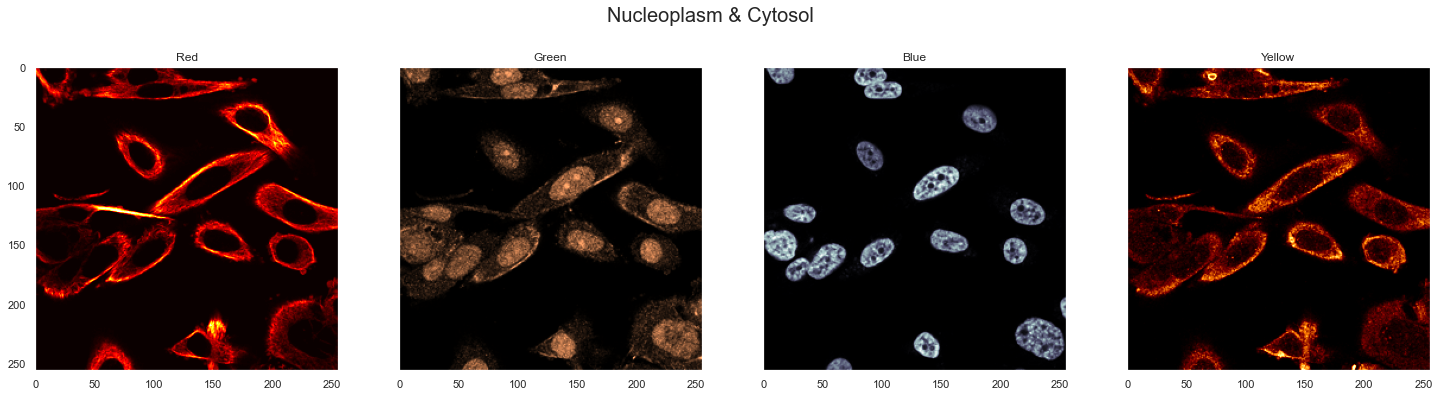

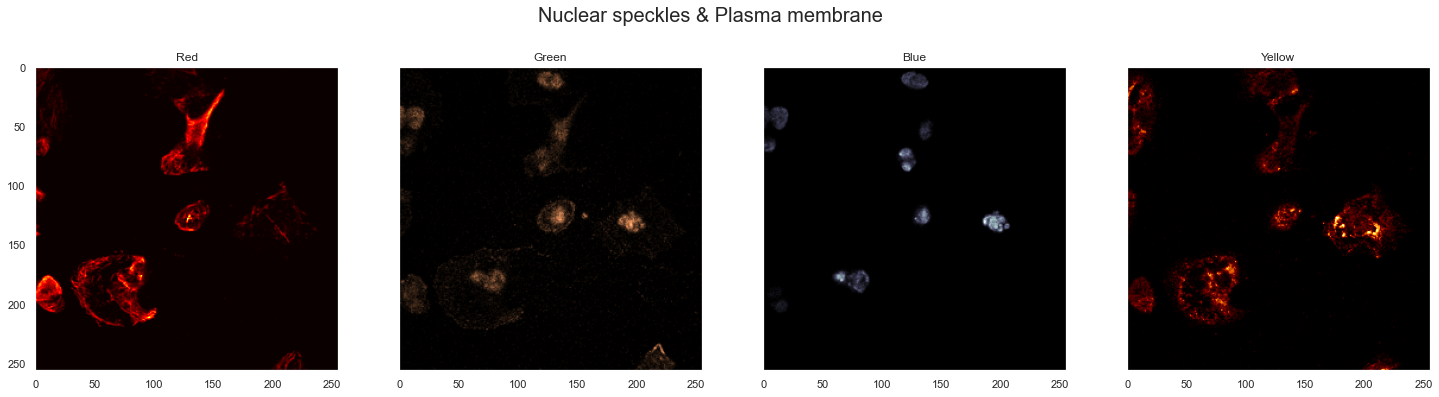

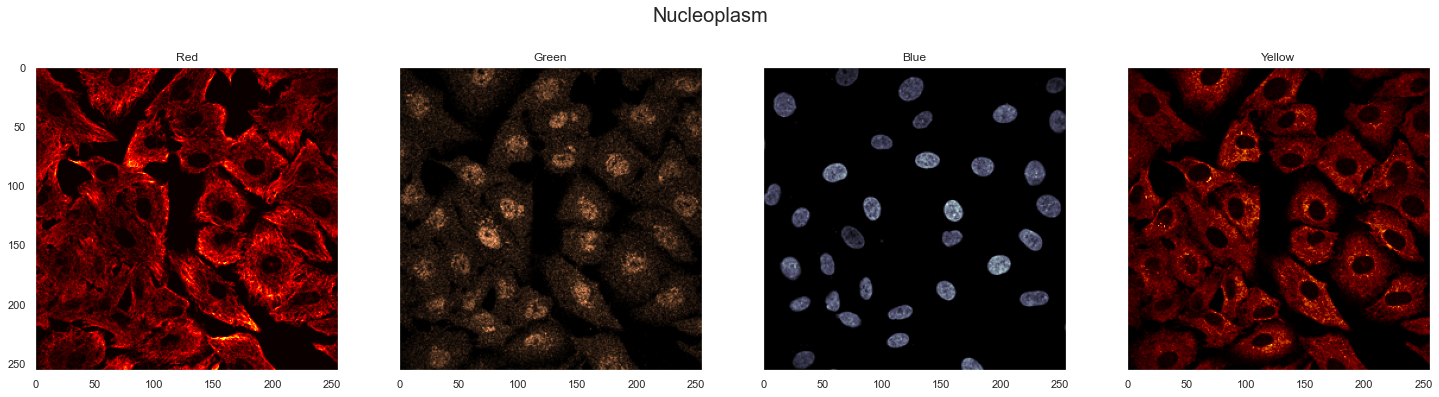

In [14]:
import random

idxs = random.sample(range(1, dataset.df.shape[0]), 3)

for idx in idxs:
    Show(dataset[idx])

# TRAINING A MODEL WITH CNN
# split training dataset into training+validation

the function prepare_loaders will call dataset.loadData, that means each time we "prepare our loaders" the dataset will contain different images for training and validation.

In [15]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import math

def prepare_loaders():
    dataset.loadData()
    num_train = len(dataset)
    indices = list(range(num_train))
    val_size = int(0.45 * num_train) 

    # Random, non-contiguous split
    validation_idx = np.random.choice(indices, size=val_size, replace=False)
    train_idx = list(set(indices) - set(validation_idx))

    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)

    dataset_sizes = {}

    dataset_sizes['train'] = len(train_idx)
    dataset_sizes['val'] = len(validation_idx)
    
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE,num_workers=0, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0,sampler=validation_sampler)

    dataloaders = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = validation_loader
    
    return (dataloaders, dataset_sizes)


In [16]:
dataloaders, dataset_sizes = prepare_loaders()

dataset.df.head()

,Id,Target,Targets
0,e1480d20-bbc6-11e8-b2bc-ac1f6b6435d0,2 21,"[2, 21]"
1,7ff20c74-bba3-11e8-b2b9-ac1f6b6435d0,7,[7]
2,d3f33330-bbca-11e8-b2bc-ac1f6b6435d0,25 21,"[25, 21]"
3,7adc4d34-bbc2-11e8-b2bb-ac1f6b6435d0,2,[2]
4,07a298f8-bba6-11e8-b2ba-ac1f6b6435d0,14 5,"[14, 5]"


# Model definition

In [17]:
# Wout = 1 + (Win - Kernel_size + 2Padding)/Stride

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(      #input: 4xWxH
            nn.Conv2d(4,8,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 8xW/2xH/2
        )
        self.conv2 = nn.Sequential(      #input: 4xWxH
            nn.Conv2d(8,16,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 16xW/4xH/4
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear( int(16 * W/4 * H/4), 900)   # fully connected layer, output 28 classes
        self.out2 = nn.Linear( 900, 28)   # fully connected layer, output 28 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        return output, x    # return x for visualization

def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

# Training function

simple training for our model. Not use validation yet.

In [18]:
# create a new subdataset for training
dataloaders, dataset_sizes = prepare_loaders()

In [19]:
losses = {}
accuracys = {}

losses['train'] = []
losses['val'] = []
accuracys['train'] = []
accuracys['val'] = []

In [23]:
def Train(model, epochs=10, criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer= None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.04, betas=(0.9, 0.99))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print("training with device: " + str(device))
    
    model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0    
            running_corrects = 0.0
    
            for i, data in enumerate(dataloaders[phase], 0):            
                # get the inputs
                inputs, labels = data['image'], data['target']

                inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)[0]
                    preds = outputs > 0
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                 # statistics
                running_loss += loss.item() * inputs.size(0)
                labels = labels.data.byte()
                running_corrects += torch.sum((labels == preds).all(1))
                                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            losses[phase].append(epoch_loss)
            accuracys[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def run_model(model,batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = batch
    inputs = inputs.to(device,dtype=torch.float)
    out = model(inputs)
    out = out[0].cpu()
    return out

In [24]:
# model creation and initialization
cnn = CNN()
cnn.apply(init_weights)

CNN(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [25]:
# training
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

Epoch 1/10
----------
train Loss: 1294.5891 Acc: 0.0236
val Loss: 1024.8037 Acc: 0.0008
Epoch 2/10
----------
train Loss: 985.0443 Acc: 0.0293
val Loss: 986.3198 Acc: 0.0003
Epoch 3/10
----------
train Loss: 942.0838 Acc: 0.0183
val Loss: 999.1351 Acc: 0.0291
Epoch 4/10
----------
train Loss: 845.7087 Acc: 0.0778
val Loss: 1054.3368 Acc: 0.0208
Epoch 5/10
----------
train Loss: 684.5960 Acc: 0.1837
val Loss: 1199.6508 Acc: 0.0294
Epoch 6/10
----------
train Loss: 494.9048 Acc: 0.3755
val Loss: 1371.9548 Acc: 0.0296
Epoch 7/10
----------
train Loss: 330.1436 Acc: 0.5725
val Loss: 1764.6587 Acc: 0.0323
Epoch 8/10
----------
train Loss: 228.8216 Acc: 0.6898
val Loss: 2136.5324 Acc: 0.0304
Epoch 9/10
----------
train Loss: 168.7459 Acc: 0.7820
val Loss: 2450.2884 Acc: 0.0368
Epoch 10/10
----------
train Loss: 110.2269 Acc: 0.8659
val Loss: 2817.0337 Acc: 0.0374
Training complete in 50m 17s
Best val Acc: 0.037383


In [ ]:
# training
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))
dataloaders, dataset_sizes = prepare_loaders()
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))


# Visualice training curve

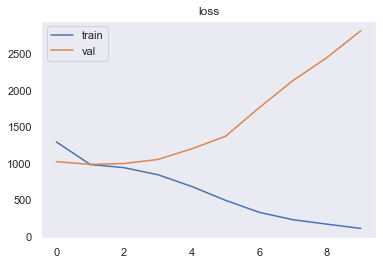

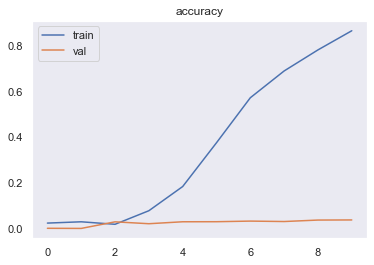

In [26]:
plt.plot(np.arange(len(losses['train'])), losses['train'],label="train")
plt.plot(np.arange(len(losses['val'])), losses['val'], label="val")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(np.arange(len(accuracys['train'])), accuracys['train'], label="train")
plt.plot(np.arange(len(accuracys['val'])), accuracys['val'], label="val")
plt.title("accuracy")
plt.legend()
plt.show()

# SAVE MODEL TO A FILE AND RESTORE FROM FILE

In [ ]:
def save(model, full = True, name="model"):
    if not full:
        torch.save(model.state_dict(), name+'_params.pkl')   # save only the parameters
    else:
        torch.save(model, name+'.pkl')  # save entire net

        
def restore_net(name="model"):
    model = torch.load(name+'.pkl')
    return model
    

In [ ]:
save(cnn, name="cnn")
!ls

In [ ]:
cnn = restore_net(name="cnn")

# SEND AND RECEIVE MODELS FROM/TO DROPBOX TO STORE THEM

We need to create a [https://www.dropbox.com/developers/apps/create](dropbox-app)  and generate an access token.

In [ ]:
#!pip install dropbox
import dropbox
dropbox_path='/'
dbx=dropbox.Dropbox('Your access token')

# upload model to dropbox

file_name='cnn.pkl'
with open(file_name, 'rb') as f:
    dbx.files_upload(f.read(),dropbox_path+file_name,mute=True, mode=dropbox.files.WriteMode.overwrite)



In [ ]:
# load model from dropbox
dbx.files_download_to_file(file_name,dropbox_path+file_name)
!ls

# submit


In [ ]:
submit = pd.read_csv('../input/sample_submission.csv')

dataset_test = HumanProteinDataset(csv_file='../input/sample_submission.csv', transform=transforms.Compose([
    ToTensor()
]), test=True)

dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)


In [ ]:
ids = []
predictions = []

cnn = cnn.cuda()

for sample_batched in dataloader_test:
        out = run_model(cnn,sample_batched['image'])
        
        preds = []
        out = out.detach().numpy()
        for sample in out:
            p = ""
            for i,label in enumerate(sample):
                if label > 0:
                    p += " " + str(i)
                    print(p)
            if p == "":
                p = "0"
            else:
                p = p[1:]
            preds.append(p)

        ids += list(sample_batched['Id'])
        predictions += preds

    


In [ ]:
print(predictions)

In [ ]:
df = pd.DataFrame({'Id':ids,'Predicted':predictions})
df.to_csv('protein_classification.csv', header=True, index=False)

print(df)


In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "protein_classification.csv"):  
    csv = df.to_csv( sep=',', encoding='utf-8', index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(df)